RL policy based on the [SoloParkour: Constrained Reinforcement Learning for Visual Locomotion from Privileged Experience](https://arxiv.org/abs/2409.13678). 

# Flat Ground

## Test In Simulation

In [1]:
from Go2Py.robot.fsm import FSM
from Go2Py.robot.remote import KeyboardRemote, XBoxRemote
from Go2Py.robot.safety import SafetyHypervisor
from Go2Py.sim.mujoco import Go2Sim
from Go2Py.control.bipedal import *
import torch

pygame 2.6.1 (SDL 2.28.4, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from Go2Py.robot.model import FrictionModel
friction_model = None
Fs = np.zeros(12)
mu_v = np.zeros(12)
#mu_v[[2,5,8,11]] = np.array([0.2167, -0.0647, -0.0420, -0.0834])
#Fs[[2,5,8,11]] = np.array([1.5259, 1.2380, 0.8917, 2.2461])

#mu_v[[0,3,6,9]] = np.array([0., 0., 0., 0.])0
#Fs[[0,3,6,9]] = np.array([1.5, 1.5, 1.5, 1.5])
#mu_v[[2,5,8,11]] = np.array([0., 0., 0., 0.])
#Fs[[2,5,8,11]] = np.array([1.5, 1.5, 1.5, 1.5])

friction_model = FrictionModel(Fs=1.5, mu_v=0.3)
#friction_model = FrictionModel(Fs=0., mu_v=0.)
#friction_model = FrictionModel(Fs=Fs, mu_v=mu_v)
robot = Go2Sim(dt = 0.001, friction_model=friction_model, async_mode=False)

In [3]:
remote = KeyboardRemote() # XBoxRemote() # KeyboardRemote()
robot.sitDownReset()
safety_hypervisor = SafetyHypervisor(robot)

In [4]:
def getRemote(remote):
    commands = remote.getCommands()
    commands[0] *= 0.
    commands[1] *= 0.
    commands[2] *= 0.
    return commands

In [5]:
class NeuroDiffSimController:
    def __init__(self, robot, remote, checkpoint):
        self.remote = remote
        self.robot = robot
        self.policy = Policy(checkpoint)
        self.command_profile = CommandInterface()
        self.agent = NeuroDiffSimAgent(self.command_profile, self.robot)
        self.hist_data = {}
        self.action_buffer = np.zeros((1, 10, 12))
        self.simulate_delay = False # True

    def init(self):
        self.obs = self.agent.reset()
        self.policy_info = {}
        self.command_profile.yaw_vel_cmd = 0.0
        self.command_profile.x_vel_cmd = 0.0
        self.command_profile.y_vel_cmd = 0.0
        
    def update(self, robot, remote):
        self.tic = time.time()
        if not hasattr(self, "obs"):
            self.init()
        commands = getRemote(remote)
        self.command_profile.yaw_vel_cmd = -commands[2]
        self.command_profile.x_vel_cmd = commands[1]
        self.command_profile.y_vel_cmd = -commands[0]

        self.obs = self.agent.get_obs()
        action = self.policy(self.obs, self.policy_info)
        if self.simulate_delay:
            current_delay = np.random.randint(0, 2)
            self.action_buffer = np.roll(self.action_buffer, shift=-1, axis=1)
            self.action_buffer[:, -1] = action.copy()
            delayed_action = self.action_buffer[:, -current_delay]
            _, self.ret, self.done, self.info = self.agent.step(delayed_action)
        else:
            _, self.ret, self.done, self.info = self.agent.step(action)
        self.toc = time.time()
        for key, value in self.info.items():
            if key in self.hist_data:
                self.hist_data[key].append(value)
            else:
                self.hist_data[key] = [value]

In [6]:
from Go2Py import ASSETS_PATH
import os
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/bipedal_demo_policy_2.pt')

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-03-03/40.pt') # <--- 
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-13-55-25/40.pt') # <--- 
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-23-2025-18-40-41/40.pt') # <--- ***

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-13-55-32/50.pt') # <--- ***
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-03-03/60.pt') # <--- *
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-08-00/50.pt') # <--- *
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-08-08/20.pt') # <--- crap
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-15-57/40.pt') # <--- crap

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-26-2025-18-08-54/60.pt') # <--- kind of working in muj and real robot with finite diff
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-26-2025-20-56-23/50.pt') # <--- kind of the same
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-26-2025-20-56-23/40.pt') # <--- untested

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-02-48-32/30.pt') # <--- good in muj
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-02-48-55/40.pt') # <--- super strong in muj
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-03-02-54/30.pt') # <--- ok in muj
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-03-02-54/40.pt') # <--- good in muj
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-03-02-57/50.pt') # <--- good in muj

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/rest_policies/02-28-2025-21-49-30/20.pt') # <--- 
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/rest_policies/02-28-2025-21-49-30/40.pt') # <--- needs finite diff
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/rest_policies/02-28-2025-21-49-30/50.pt') # <--- okay

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies/02-28-2025-23-43-40/30.pt') # <--- okay
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies/02-28-2025-23-43-40/60.pt') # <--- okay
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies/03-01-2025-00-25-47/20.pt') # <--- okay
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies/03-01-2025-00-25-47/60.pt') # <--- okay

# checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies_2/03-01-2025-01-00-06/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies_2/03-01-2025-01-00-06/30.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies_2/03-01-2025-00-59-56/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies_2/03-01-2025-00-59-56/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies_2/03-01-2025-00-59-56/60.pt') # best on real robot but drifts
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies_2/03-14-2025-18-15-08/60.pt')

# 03-18-2025
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-29-27/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-39-03/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-39-03/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-39-03/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-39-03/60.pt')

# 03-19-2025
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test3/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test3/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/03-19-2025-18-28-35/30.pt') <--- very good, but drifts

# 03-20-2025
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-18-28-35/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-22-42-14/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-22-42-14/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-22-42-14/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-22-42-14/60.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-11-52-54/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-11-52-54/30.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-11-52-54/40.pt')
#checkpoint_path = os.path.jagentoin(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-12-00-41/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-12-00-57/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-12-00-57/30.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-12-01-54/60.pt')

# 05-05-2025
# PD controller stiffness = 40
checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/t_try/05-04-2025-18-59-36/50.pt') # PD controller stiffness = 40
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/t_try/05-04-2025-18-59-37/40.pt') # PD controller stiffness = 40
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/t_try/05-04-2025-18-59-37/60.pt') # PD controller stiffness = 40

controller = NeuroDiffSimController(robot, remote, checkpoint_path)

for i in range(12):
    controller.agent.p_gains[i] = 40.0

decimation = 20
fsm = FSM(robot, remote, safety_hypervisor, control_dT=decimation * robot.dt, user_controller_callback=controller.update)

Sequential(
  (0): Linear(in_features=305, out_features=256, bias=True)
  (1): SiLU()
  (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): SiLU()
  (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): SiLU()
  (8): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
)
Exported model has been tested with ONNXRuntime, and the result looks good!
p_gains: [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]


/opt/conda/envs/go2py/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [7]:
fsm.close()

In [9]:
robot.sitDownReset()

# Slippage Analysis

In [ ]:
contacts = []
feet_vels = []

while True:
    if remote.xbox_controller.digital_cmd[1]:
        break
    contact_state = robot.getFootContact()>15
    sites = ['FR_foot', 'FL_foot', 'RR_foot', 'RL_foot']
    feet_vel = [np.linalg.norm(robot.getFootVelInWorld(s)) for s in sites]
    contacts.append(contact_state)
    feet_vels.append(feet_vel)
    time.sleep(0.01)

feet_vels = np.stack(feet_vels)
contacts = np.stack(contacts)

In [ ]:
import matplotlib.pyplot as plt
start = 300
end = 1200
plt.plot(contacts[start:end,0])
plt.plot(feet_vels[start:end,0])
plt.legend(['contact state', 'foot velocity'])
plt.grid(True)
plt.tight_layout()
plt.savefig('foot_slipping_fric0.2.png')

**To Do**
- Train a policy without any actuator friction and check the plots for friction 0.2 and 0.6 
- Do the same experiment for the walk-these-ways policy
- While testing the walk these ways, check the output of the adaptation module for various friction numbers, any correlation?

In [8]:
fsm.close()

## Foot Contanct Analysis

In [ ]:
np.array(controller.hist_data["body_pos"])[0, 0, -1]

In [ ]:
plt.plot(np.array(controller.hist_data["body_pos"])[:, 0, -1])

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["torques"]' is a dictionary with torque profiles
torques = np.array(controller.hist_data["body_linear_vel"])[:, 0, :, 0]

# Number of torque profiles
torque_nb = torques.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(torque_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each torque profile
for i in range(torque_nb):
    axes[i].plot(np.arange(torques.shape[0]) * robot.dt * decimation, torques[:, i])
    axes[i].set_title(f'Torque {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Torque Value')
    axes[i].grid(True)

# Remove any empty subplots if torque_nb is not a multiple of 3
for j in range(torque_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("torque_profile.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["torques"]' is a dictionary with torque profiles
torques = np.array(controller.hist_data["torques"])

# Number of torque profiles
torque_nb = torques.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(torque_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each torque profile
for i in range(torque_nb):
    axes[i].plot(np.arange(torques.shape[0]) * robot.dt * decimation, torques[:, i])
    axes[i].set_title(f'Torque {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Torque Value')
    axes[i].grid(True)

# Remove any empty subplots if torque_nb is not a multiple of 3
for j in range(torque_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("torque_profile.png")
plt.show()

In [ ]:
# Extract the joint position data for the first joint over time
joint_pos = np.array(controller.hist_data["joint_vel"])[:, 0]

# Number of data points in joint_pos
n_data_points = len(joint_pos)

# Since you're plotting only one joint, no need for multiple subplots in this case.
# But to follow the grid requirement, we'll replicate the data across multiple subplots.
# For example, let's assume you want to visualize this data 9 times in a 3x3 grid.

n_cols = 3
n_rows = int(np.ceil(torque_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot the same joint position data in every subplot (as per grid requirement)
for i in range(n_rows * n_cols):
    axes[i].plot(joint_pos[:, i])
    axes[i].set_title(f'Joint Position {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Position Value')

# Adjust layout
plt.tight_layout()
plt.savefig("joint_position_profile.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["foot_contact_forces_mag"]' is a dictionary with foot contact force magnitudes
foot_contact_forces_mag = np.array(controller.hist_data["foot_contact_forces_mag"])

# Number of feet (foot_nb)
foot_nb = foot_contact_forces_mag.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(foot_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each foot's contact force magnitude
for i in range(foot_nb):
    axes[i].plot(foot_contact_forces_mag[:, i])
    axes[i].set_title(f'Foot {i+1} Contact Force Magnitude')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Force Magnitude')

# Remove any empty subplots if foot_nb is not a multiple of 3
for j in range(foot_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("foot_contact_profile.png")
plt.show()

In [ ]:
# Extract the joint acceleration data for the first joint over time
joint_acc = np.array(controller.hist_data["joint_acc"])[:, 0]

# Number of data points in joint_acc
n_data_points = len(joint_acc)

# Number of feet (foot_nb)
foot_nb = joint_acc.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(foot_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the same joint acceleration data in every subplot (as per grid requirement)
for i in range(n_rows * n_cols):
    axes[i].plot(joint_acc[:, i])
    axes[i].set_title(f'Joint Acceleration {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Acceleration Value')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Extract the joint jerk data over time
joint_jerk = np.array(controller.hist_data["joint_jerk"])[:, 0]

# Number of data points in joint_jerk
n_data_points = len(joint_jerk)

# Number of joints (assuming the second dimension corresponds to joints)
num_joints = joint_jerk.shape[1]

# Number of columns per row in the subplot grid
n_cols = 3
# Number of rows needed for the grid
n_rows = int(np.ceil(num_joints / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the joint jerk data for each joint
for i in range(num_joints):
    axes[i].plot(joint_jerk[:, i])
    axes[i].set_title(f'Joint Jerk {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Jerk Value')

# Hide any unused subplots
for i in range(num_joints, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
# Extract the foot contact rate data over time
foot_contact_rate = np.array(controller.hist_data["foot_contact_rate"])[:, 0]

# Number of data points in foot_contact_rate
n_data_points = foot_contact_rate.shape[0]

# Number of feet (assuming the second dimension corresponds to feet)
num_feet = foot_contact_rate.shape[1]

# Number of columns per row in the subplot grid
n_cols = 3
# Number of rows needed for the grid
n_rows = int(np.ceil(num_feet / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the foot contact rate data for each foot
for i in range(num_feet):
    axes[i].plot(foot_contact_rate[:, i])
    axes[i].set_title(f'Foot Contact Rate {i+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Contact Rate')

# Hide any unused subplots
for i in range(num_feet, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Test on Real Robot (ToDo)

In [1]:
from Go2Py.robot.fsm import FSM
from Go2Py.robot.remote import XBoxRemote
from Go2Py.robot.safety import SafetyHypervisor
from Go2Py.control.bipedal import *
from Go2Py.robot.remote import UnitreeRemote, KeyboardRemote

pygame 2.6.1 (SDL 2.28.4, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from Go2Py.robot.interface import GO2Real
import numpy as np
robot = GO2Real(mode='lowlevel')

In [3]:
remote = UnitreeRemote(robot) # KeyboardRemote() # UnitreeRemote(robot) # XBoxRemote() # KeyboardRemote()
safety_hypervisor = SafetyHypervisor(robot)

In [4]:
robot.getJointStates()

{'q': [-0.06855577230453491,
  1.2771508693695068,
  -2.808267593383789,
  -0.003413960337638855,
  1.2987688779830933,
  -2.8537471294403076,
  -0.3406650424003601,
  1.323621392250061,
  -2.8562748432159424,
  0.2869526743888855,
  1.3023967742919922,
  -2.821584701538086],
 'dq': [0.03875523805618286,
  0.027128666639328003,
  0.03033018670976162,
  0.046506285667419434,
  0.07751047611236572,
  -0.026286162436008453,
  -0.054257333278656006,
  0.01937761902809143,
  -0.010110062547028065,
  -0.015502095222473145,
  0.06588390469551086,
  -0.026286162436008453],
 'tau_est': [-0.17316797375679016,
  0.17316797375679016,
  -0.23707520961761475,
  -0.17316797375679016,
  -0.22264453768730164,
  0.3319052755832672,
  0.049476563930511475,
  0.049476563930511475,
  -0.04741504043340683,
  0.049476563930511475,
  -0.049476563930511475,
  0.09483008086681366],
 'temperature': [35.0,
  30.0,
  31.0,
  33.0,
  30.0,
  32.0,
  36.0,
  31.0,
  32.0,
  37.0,
  31.0,
  32.0]}

In [5]:
robot.getForwardVecInBody()

array([[ 0.99409114],
       [ 0.06815925],
       [-0.08448155]])

Make sure the robot can take commands from python. The next cell should make the joints free to move (no damping).

In [6]:
dq_real = robot.getJointStates()['dq'].copy()

In [7]:
qpos

NameError: name 'qpos' is not defined

In [8]:
import numpy as np
import time
start_time = time.time()
dqs_real = []
dqs_est = []
prev_qpos = np.array(robot.getJointStates()['q'].copy())
while time.time()-start_time < 30:
    dq_real = np.array(robot.getJointStates()['dq'].copy())
    qpos = np.array(robot.getJointStates()['q'].copy())
    dqs_real.append(dq_real)
    dq_est = ((qpos - prev_qpos) / 0.02)
    dqs_est.append(dq_est)
    prev_qpos = qpos.copy()
    q = np.zeros(12) 
    dq = np.zeros(12)
    kp = np.ones(12)*0.0
    kd = np.ones(12)*0.0
    tau = np.zeros(12)
    tau[0] = 0.0
    robot.setCommands(q, dq, kp, kd, tau)
    time.sleep(0.02)

KeyboardInterrupt: 

In [7]:
dqs_real = np.array(dqs_real)
dqs_est = np.array(dqs_est)

1746564629.646481 [0]        tev: ddsi_udp_conn_write to udp/239.255.0.1:7400 failed with retcode -1
1746564629.646532 [0]        tev: ddsi_udp_conn_write to udp/192.168.123.18:7410 failed with retcode -1
1746564631.246617 [0]        tev: ddsi_udp_conn_write to udp/192.168.123.18:7410 failed with retcode -1
1746564631.246654 [0]        tev: ddsi_udp_conn_write to udp/192.168.123.18:49061 failed with retcode -1
1746564632.846777 [0]        tev: ddsi_udp_conn_write to udp/192.168.123.18:7410 failed with retcode -1
1746564634.244778 [0]        tev: ddsi_udp_conn_write to udp/192.168.123.18:7410 failed with retcode -1
1746564634.344767 [0]        tev: ddsi_udp_conn_write to udp/192.168.123.18:7410 failed with retcode -1
1746564634.344809 [0]        tev: ddsi_udp_conn_write to udp/239.255.0.1:7400 failed with retcode -1
1746564634.344828 [0]        tev: ddsi_udp_conn_write to udp/192.168.123.18:7410 failed with retcode -1
1746564634.444924 [0]        tev: ddsi_udp_conn_write to udp/192.168.

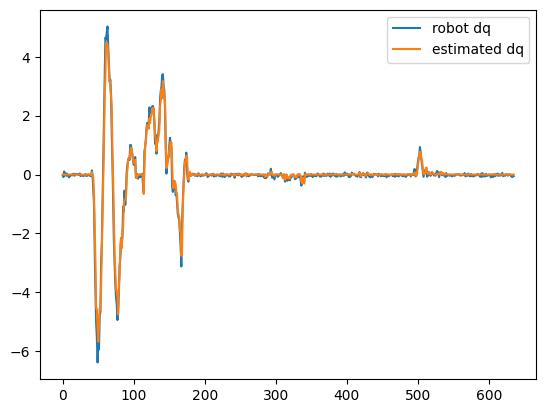

In [7]:
import matplotlib.pyplot as plt
plt.plot(dqs_real[800:2000, 1])
plt.plot(dqs_est[800:2000,1])
plt.legend(['robot dq', 'estimated dq'])

In [ ]:
dqs_est.shape

In [9]:
"""def getRemote(remote):
    commands = remote.getCommands()
    commands[0] *= 0.6
    commands[1] *= 0.6
    zero_commands = np.logical_and(
        np.linalg.norm(commands[:2]) <= 0.2,
        np.abs(commands[2]) <= 0.2
    )
    if zero_commands:
        commands = np.zeros_like(commands)
    return commands"""
def getRemote(remote):
    vy = -robot.getRemoteState().lx
    vx = robot.getRemoteState().ly
    omega = -robot.getRemoteState().rx
    commands = [vy, vx, omega]
    commands[0] *= 0.
    commands[1] *= 0.
    commands[2] *= 0.
    return commands

In [10]:
class NeuroDiffSimController:
    def __init__(self, robot, remote, checkpoint):
        self.remote = remote
        self.robot = robot
        self.policy = Policy(checkpoint)
        self.command_profile = CommandInterface()
        self.agent = NeuroDiffSimAgent(self.command_profile, self.robot)
        self.hist_data = {}

    def init(self):
        self.obs = self.agent.reset()
        self.policy_info = {}
        self.command_profile.yaw_vel_cmd = 0.0
        self.command_profile.x_vel_cmd = 0.0
        self.command_profile.y_vel_cmd = 0.0

    def update(self, robot, remote):
        if not hasattr(self, "obs"):
            self.init()
        commands = getRemote(remote)
        self.command_profile.yaw_vel_cmd = -commands[2]
        self.command_profile.x_vel_cmd = commands[1]
        self.command_profile.y_vel_cmd = -commands[0]

        self.obs = self.agent.get_obs()
        action = self.policy(self.obs, self.policy_info)
        _, self.ret, self.done, self.info = self.agent.step(action)
        for key, value in self.info.items():
            if key in self.hist_data:
                self.hist_data[key].append(value)
            else:
                self.hist_data[key] = [value]

In [11]:
from Go2Py import ASSETS_PATH 
import os
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/bipedal_demo_policy_2.pt')

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-03-03/40.pt') # <--- 
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-13-55-25/40.pt') # <--- 
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-23-2025-18-40-41/40.pt') # <--- ***

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-13-55-32/50.pt') # <--- ***
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-03-03/60.pt') # <--- *
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-08-00/50.pt') # <--- *
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-08-08/20.pt') # <--- crap
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-25-2025-14-15-57/40.pt') # <--- crap

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-26-2025-18-08-54/60.pt') # <---
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-26-2025-20-56-23/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-26-2025-20-56-23/40.pt')

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-27-2025-13-32-21/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-27-2025-17-18-42/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-27-2025-17-18-42/60.pt') # <--- something
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-27-2025-13-26-17/20.pt') # <--- strap helped it
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-27-2025-13-26-17/30.pt') # <--- works but slips - best so far on real robot
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/02-27-2025-13-26-17/40.pt')

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-02-48-32/30.pt') # <--- good in muj
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-02-48-55/40.pt') # <--- super strong in muj
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-03-02-54/30.pt') # <--- ok in muj
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-03-02-54/40.pt') # <--- good in muj
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/slip_policies/02-28-2025-03-02-57/50.pt') # <--- good in muj

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/rest_policies/02-28-2025-21-49-30/40.pt') # <--- needs finite diff
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/rest_policies/02-28-2025-21-49-30/50.pt') # <--- okay

#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies/02-28-2025-23-43-40/30.pt') # <--- okay
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies/02-28-2025-23-43-40/60.pt') # <--- okay
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies/03-01-2025-00-25-47/20.pt') # <--- okay, really good?
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies/03-01-2025-00-25-47/60.pt') # <--- okay, works
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/some_policies_2/03-14-2025-18-15-08/60.pt')

# 03-18-2025
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-29-27/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-39-03/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-39-03/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-39-03/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test2/03-17-2025-14-39-03/60.pt')

# 03-19-2025
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test3/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test3/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/03-19-2025-18-28-35/30.pt') <--- very good, but drifts

# 03-20-2025
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-18-28-35/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-22-42-14/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-22-42-14/40.pt') # <--- very cool, working
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-22-42-14/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-19-2025-22-42-14/60.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-11-52-54/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-11-52-54/30.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-11-52-54/40.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-12-00-41/50.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-12-00-57/20.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-12-00-57/30.pt')
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/to_test4/03-20-2025-12-01-54/60.pt')

# 05-05-2025
# PD controller stiffness = 40
checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/t_try/05-04-2025-18-59-36/50.pt') # PD controller stiffness = 40 <--- very cool, working
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/t_try/05-04-2025-18-59-37/40.pt') # PD controller stiffness = 40
#checkpoint_path = os.path.join(ASSETS_PATH, 'checkpoints/neuro_diff_sim/policies/t_try/05-04-2025-18-59-37/60.pt') # PD controller stiffness = 40

controller = NeuroDiffSimController(robot, remote, checkpoint_path)

for i in range(12):
    controller.agent.p_gains[i] = 40.0

Sequential(
  (0): Linear(in_features=305, out_features=256, bias=True)
  (1): SiLU()
  (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): SiLU()
  (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): SiLU()
  (8): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
)


/opt/conda/envs/go2py/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Exported model has been tested with ONNXRuntime, and the result looks good!
p_gains: [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]


In [12]:
fsm = FSM(robot, remote, safety_hypervisor, control_dT=1./50., user_controller_callback=controller.update)

In [13]:
fsm.close()